TODO: REVISE
# Data Analysis Tutorial - Innate Immune System Proteins
In this tutorial, we will be looking at the set of protein interactions in the innate immune system, and see if we can find any trends between the graphical properties of proteins in the interaction network and their biological properties. 

## Initial Guesses
Before we begin looking for or analyzing data, we set some goals to provide direction, and so we make some theories. 
For the graphical properties, we can look at the degree of a protein (how many proteins this protein interacts with), and degrees of centrality, such as how many paths go through this protein. 
On the biological side, scientists have been able to take measurements on a massive number of proteins. Proteins are a sequence of amino acids that have folded in a particular way to act as catalysts for various chemical processes. One of the main things measured for a protein is its sequence, ie the composition of the string of amino acids. These sequences can be on the order of 100 amino acids long, and with 20 different amino acids and possibly several ways of folding the chain into a 3d shape, trying to analyze the sequence outside of possibly the number of amino acids present is outside the scope of this project. 
Other properties include the mass and length of a protein, the domains (3d substructures) in the protein, the biological processes it is involved in, and the locations in the tissue. 

We predict that proteins with a high degree, or degree of centrality will likely be larger, so as to have more locations on the protein where an interaction can take place. Further, we predict that these proteins will likely be spread out in the cell and the tissue, being present in multiple tissues/subcellular regions instead of just one or two. With more interactions, we also predict that the proteins will be involved in more biological processes. 

In [213]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
import io
import time

TODO: WHERE IS DATA FROM

In [52]:
# Making a dataframe out of the innate immune system data file, and getting characteristics from it. 

interactionDF = pd.read_csv("./all.mitab/all.mitab", sep = "\t")
print(interactionDF.info())
pd.set_option('display.max_rows', None, 'display.max_columns', None)
display(interactionDF.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418677 entries, 0 to 418676
Data columns (total 42 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   #unique_identifier_A                 418677 non-null  object
 1   unique_identifier_B                  418677 non-null  object
 2   alt_identifier_A                     418677 non-null  object
 3   alt_identifier_B                     418677 non-null  object
 4   alias_A                              418677 non-null  object
 5   alias_B                              418677 non-null  object
 6   interaction_detection_method         418677 non-null  object
 7   author                               418677 non-null  object
 8   pmid                                 418677 non-null  object
 9   ncbi_taxid_A                         418677 non-null  object
 10  ncbi_taxid_B                         418677 non-null  object
 11  interaction_type          

,#unique_identifier_A,unique_identifier_B,alt_identifier_A,alt_identifier_B,alias_A,alias_B,interaction_detection_method,author,pmid,ncbi_taxid_A,ncbi_taxid_B,interaction_type,source_database,idinteraction_in_source_db,confidence_score,expansion_method,biological_role_A,biological_role_B,exp_role_A,exp_role_B,interactor_type_A,interactor_type_B,xrefs_A,xrefs_B,xrefs_interaction,annotations_A,annotations_B,annotations_interaction,ncbi_taxid_host_organism,parameters_interaction,creation_date,update_date,checksum_A,checksum_B,checksum_interaction,negative,features_A,features_B,stoichiometry_A,stoichiometry_B,participant_identification_method_A,participant_identification_method_B
0,innatedb:IDBG-90895,innatedb:IDBG-90895,ensembl:ENSG00000132906,ensembl:ENSG00000132906,uniprotkb:CASP9_HUMAN|refseq:NP_127463|uniprot...,uniprotkb:CASP9_HUMAN|refseq:NP_127463|uniprot...,"psi-mi:""MI:0114""(x-ray crystallography)",Renatus et al. (2001),pubmed:11734640,taxid:9606(Human),taxid:9606(Human),"psi-mi:""MI:0915""(physical association)",MI:0462(bind),BIND:100139,lpr:4|hpr:4|np:1|,-,"psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0326""(protein)","psi-mi:""MI:0326""(protein)",-,-,-,-,-,"comment:""BIND interaction division: BIND-3DBP; """,taxid:0,-,2014/11/29,2014/11/29,-,-,-,False,-,-,-,-,"psi-mi:""MI:0363""(inferred by author)","psi-mi:""MI:0363""(inferred by author)"
1,innatedb:IDBG-90895,innatedb:IDBG-90895,ensembl:ENSG00000132906,ensembl:ENSG00000132906,uniprotkb:CASP9_HUMAN|refseq:NP_127463|uniprot...,uniprotkb:CASP9_HUMAN|refseq:NP_127463|uniprot...,"psi-mi:""MI:0114""(x-ray crystallography)",Renatus et al. (2001),pubmed:11734640,taxid:9606(Human),taxid:9606(Human),"psi-mi:""MI:0915""(physical association)",MI:0462(bind),BIND:100140,lpr:4|hpr:4|np:1|,-,"psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0326""(protein)","psi-mi:""MI:0326""(protein)",-,-,-,-,-,"comment:""BIND interaction division: BIND-3DBP; """,taxid:0,-,2014/11/29,2014/11/29,-,-,-,False,-,-,-,-,"psi-mi:""MI:0363""(inferred by author)","psi-mi:""MI:0363""(inferred by author)"
2,innatedb:IDBG-90895,innatedb:IDBG-90895,ensembl:ENSG00000132906,ensembl:ENSG00000132906,uniprotkb:CASP9_HUMAN|refseq:NP_127463|uniprot...,uniprotkb:CASP9_HUMAN|refseq:NP_127463|uniprot...,"psi-mi:""MI:0114""(x-ray crystallography)",Renatus et al. (2001),pubmed:11734640,taxid:9606(Human),taxid:9606(Human),"psi-mi:""MI:0915""(physical association)",MI:0462(bind),BIND:100141,lpr:4|hpr:4|np:1|,-,"psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0326""(protein)","psi-mi:""MI:0326""(protein)",-,-,-,-,-,"comment:""BIND interaction division: BIND-3DBP; """,taxid:0,-,2014/11/29,2014/11/29,-,-,-,False,-,-,-,-,"psi-mi:""MI:0363""(inferred by author)","psi-mi:""MI:0363""(inferred by author)"
3,innatedb:IDBG-96746,innatedb:IDBG-73725,ensembl:ENSG00000084072,ensembl:ENSG00000118058,refseq:NP_982281|uniprotkb:PPIE_HUMAN|uniprotk...,uniprotkb:MLL1_HUMAN|refseq:NP_005924|uniprotk...,"psi-mi:""MI:0018""(two hybrid)",Fair et al.(2001),pubmed:11313484,taxid:9606(Human),taxid:9606(Human),"psi-mi:""MI:0915""(physical association)",MI:0463(biogrid),BIOGRID:10022,lpr:6|hpr:6|np:1|,-,"psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0499""(unspecified role)","psi-mi:""MI:0498""(prey)","psi-mi:""MI:0496""(bait)","psi-mi:""MI:0326""(protein)","psi-mi:""MI:0326""(protein)",-,-,-,-,-,"comment:""BioGRID Evidence Code: Two-hybrid; """,taxid:32644,-,2014/11/29,2014/11/29,-,-,-,False,-,-,-,-,"psi-mi:""MI:0396""(predetermined participant)","psi-mi:""MI:0396""(predetermined participant)"
4,innatedb:IDBG-75670,innatedb:IDBG-75670,ensembl:ENSG00000148090,ensembl:ENSG00000148090,unip

TODO: TAKE A LOOK PROSE

(407990, 2)


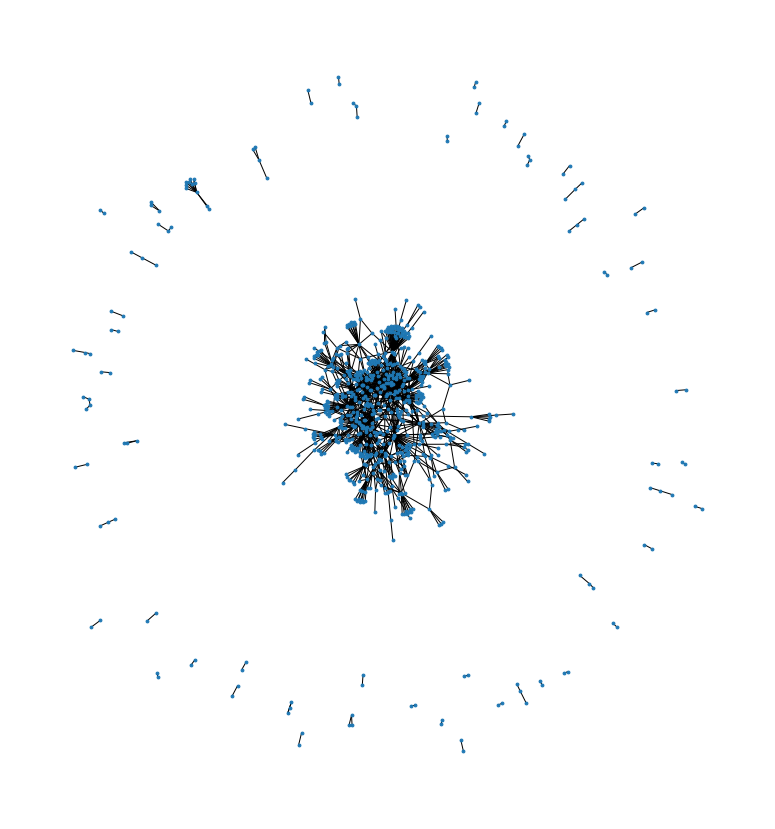

1079


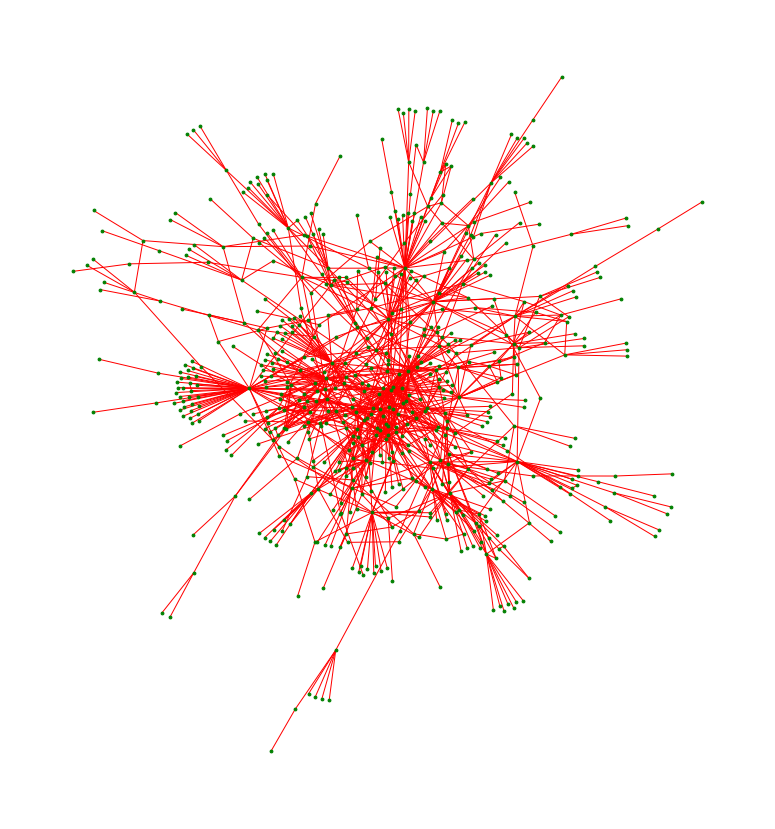

In [55]:
# Taking a look at the network
edgeList = interactionDF[["#unique_identifier_A", "unique_identifier_B"]]
# removing self interaction edges, to reduce clutter
edgeListNoSelf = edgeList[edgeList["#unique_identifier_A"] != edgeList["unique_identifier_B"]]
print(edgeListNoSelf.shape)
G = nx.Graph(list(np.array(edgeListNoSelf.head(2000))))
plt.figure(figsize = [30,15])
subax1 = plt.subplot(121)
nx.draw(G, node_size = 8)
plt.show()
# getting the largest component
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
Sl = max(S, key=len)
print(Sl.size())
plt.figure(figsize = [30,15])
subax1 = plt.subplot(121)
nx.draw(Sl, node_size = 8, node_color = "green", edge_color = "red")
plt.show()

TODO: UNKNOWN VALUES, USEFUL COLUMNS. WANT MORE DATA ON PROTEIN: UNIPROTKB. GRAPH OBSERVATION
## Uniprot
Start by mapping proteins to uniprotkb ids

In [217]:
# Defining function to get the uniprotkb protein id, if it exists. 
def getUniprotkb(str):
    r = re.search("uniprotkb:([^_|]+)[|]", str + "|")
    if r:
        return r.group(1)
    else:
        return "NONE"

In [218]:
# TODO ADD LENGTH CHECKS
# get mapping from innatedb unique identifier to uniprot ID
aProts = (interactionDF["#unique_identifier_A"] + "->" + interactionDF["alias_A"]).unique()
bProts = (interactionDF["unique_identifier_B"] + "->" + interactionDF["alias_B"]).unique()
allProts = np.unique(np.concatenate((aProts, bProts), axis = 0))

protDF  = pd.DataFrame([i.split("->") for i in allProts], columns = ["innateDB_ID","alias"])
protDF["UniprotID"] = protDF["alias"].apply(getUniprotkb)

# Display head, get the number of entries without a uniprotID
print(f"{pd.isna(protDF['UniprotID']).sum()} entries are missing a uniprotID out of {protDF.shape[0]}")
display(protDF.head())
print(f"Number of unique innatedb ids: {len(protDF['innateDB_ID'].unique())}")


0 entries are missing a uniprotID out of 25271


,innateDB_ID,alias,UniprotID
0,innatedb:IDBG-1,refseq:NP_003131|uniprotkb:Q05066|uniprotkb:SR...,Q05066
1,innatedb:IDBG-100000,uniprotkb:LPAR3_HUMAN|refseq:NP_036284|uniprot...,Q9UBY5
2,innatedb:IDBG-100012,uniprotkb:Q8IWG1|uniprotkb:WDR63_HUMAN|refseq:...,Q8IWG1
3,innatedb:IDBG-10002,refseq:NP_056518|uniprotkb:Q9Y3A4|uniprotkb:RR...,Q9Y3A4
4,innatedb:IDBG-100021,uniprotkb:MCLN3_HUMAN|uniprotkb:Q8TDD5|refseq:...,Q8TDD5


Number of unique innatedb ids: 25271


### Querying
now we query uniprot TODO (describe API)

In [219]:
# breaking the queries into blocks
def makeQueryList(n, ids):
    numBlocks = int((len(ids)/n + 1) - len(ids)/n % 1)
    queryList = []
    for i in range(numBlocks - 1):
        entry = "id:" + ids[i*n]
        for j in range(n-1):
            entry = entry + "+OR+id:" + ids[i*n + 1 + j]
        queryList.append(entry)
    entry = ids[(numBlocks-1)*n]
    for j in range(len(ids) - (numBlocks-1)*n - 1):
        entry = entry + "+OR+" + ids[(numBlocks-1)*n + 1 + j]
    return queryList

proteinQueryList = makeQueryList(100, np.array(protDF[~pd.isna(protDF['UniprotID'])]['UniprotID']))
columns = "columns=id,entry name,organism,mass,length,comment(TISSUE SPECIFICITY),comment(DISEASE),comment(SUBCELLULAR LOCATION),go,comment(DOMAIN),families,feature(DOMAIN EXTENT)"
fmt = "format=tab"

Progress
____________________________________________________________________________________________________

In [227]:
# querying the database for information on the proteins
colQuery = requests.get("https://www.uniprot.org/uniprot/?query=" + protDF[~pd.isna(protDF['UniprotID'])]['UniprotID'][0] + "&" + columns + "&" + fmt)
temp = pd.read_csv(io.StringIO(colQuery.text), sep = "\t")
uniprotDF = pd.DataFrame(columns = temp.columns)
print("Progress\n" + "_"*100)
for i in range(len(proteinQueryList)):
    # make request
    r = requests.get("https://www.uniprot.org/uniprot/?query=" + proteinQueryList[i] + "&" + columns + "&" + fmt)
    temp = pd.read_csv(io.StringIO(r.text), sep = "\t")
    uniprotDF = uniprotDF.merge(temp, how = "outer")
    if i/len(proteinQueryList) % .01 < (i-1)/len(proteinQueryList) % .01: print("=", end = "")
    time.sleep(1)

Progress
____________________________________________________________________________________________________

In [228]:
print(uniprotDF.shape)
display(uniprotDF.head())

(23655, 12)


,Entry,Entry name,Organism,Mass,Length,Tissue specificity,Involvement in disease,Subcellular location [CC],Gene ontology (GO),Domain [CC],Protein families,Domain [FT]
0,P19320,VCAM1_HUMAN,Homo sapiens (Human),"81,276",739.0,TISSUE SPECIFICITY: Expressed on inflamed vasc...,NaN,SUBCELLULAR LOCATION: Membrane; Single-pass ty...,alpha9-beta1 integrin-vascular cell adhesion m...,DOMAIN: Either the first or the fourth Ig-like...,NaN,"DOMAIN 25..105; /note=""Ig-like C2-type 1""; DO..."
1,P36543,VATE1_HUMAN,Homo sapiens (Human),"26,145",226.0,TISSUE SPECIFICITY: Kidney; localizes to early...,"DISEASE: Cutis laxa, autosomal recessive, 2C (...",SUBCELLULAR LOCATION: Apical cell membrane {EC...,apical plasma membrane [GO:0016324]; cytosol [...,NaN,V-ATPase E subunit family,NaN
2,Q9UKA9,PTBP2_HUMAN,Homo sapiens (Human),"57,491",531.0,TISSUE SPECIFICITY: Mainly expressed in brain ...,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000250|Uni...,growth cone [GO:0030426]; neuronal cell body [...,NaN,NaN,"DOMAIN 59..133; /note=""RRM 1""; /evidence=""EC..."
3,Q96NR8,RDH12_HUMAN,Homo sapiens (Human),"35,094",316.0,"TISSUE SPECIFICITY: Widely expressed, mostly i...",DISEASE: Leber congenital amaurosis 13 (LCA13)...,SUBCELLULAR LOCATION: Endoplasmic reticulum me...,endoplasmic reticulum membrane [GO:0005789]; p...,NaN,Short-chain dehydrogenases/reductases (SDR) fa...,NaN
4,Q52LW3,RHG29_HUMAN,Homo sapiens (Human),"142,064",1261.0,TISSUE SPECIFICITY: Widely expressed. Highly e...,NaN,NaN,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,NaN,NaN,"DOMAIN 192..462; /note=""F-BAR""; /evidence=""E..."


In [231]:
print(protDF.shape)
print(uniprotDF.shape)

display(protDF.head())
display(uniprotDF.head())

(25271, 3)
(23655, 12)


,innateDB_ID,alias,UniprotID
0,innatedb:IDBG-1,refseq:NP_003131|uniprotkb:Q05066|uniprotkb:SR...,Q05066
1,innatedb:IDBG-100000,uniprotkb:LPAR3_HUMAN|refseq:NP_036284|uniprot...,Q9UBY5
2,innatedb:IDBG-100012,uniprotkb:Q8IWG1|uniprotkb:WDR63_HUMAN|refseq:...,Q8IWG1
3,innatedb:IDBG-10002,refseq:NP_056518|uniprotkb:Q9Y3A4|uniprotkb:RR...,Q9Y3A4
4,innatedb:IDBG-100021,uniprotkb:MCLN3_HUMAN|uniprotkb:Q8TDD5|refseq:...,Q8TDD5


,Entry,Entry name,Organism,Mass,Length,Tissue specificity,Involvement in disease,Subcellular location [CC],Gene ontology (GO),Domain [CC],Protein families,Domain [FT]
0,P19320,VCAM1_HUMAN,Homo sapiens (Human),"81,276",739.0,TISSUE SPECIFICITY: Expressed on inflamed vasc...,NaN,SUBCELLULAR LOCATION: Membrane; Single-pass ty...,alpha9-beta1 integrin-vascular cell adhesion m...,DOMAIN: Either the first or the fourth Ig-like...,NaN,"DOMAIN 25..105; /note=""Ig-like C2-type 1""; DO..."
1,P36543,VATE1_HUMAN,Homo sapiens (Human),"26,145",226.0,TISSUE SPECIFICITY: Kidney; localizes to early...,"DISEASE: Cutis laxa, autosomal recessive, 2C (...",SUBCELLULAR LOCATION: Apical cell membrane {EC...,apical plasma membrane [GO:0016324]; cytosol [...,NaN,V-ATPase E subunit family,NaN
2,Q9UKA9,PTBP2_HUMAN,Homo sapiens (Human),"57,491",531.0,TISSUE SPECIFICITY: Mainly expressed in brain ...,NaN,SUBCELLULAR LOCATION: Nucleus {ECO:0000250|Uni...,growth cone [GO:0030426]; neuronal cell body [...,NaN,NaN,"DOMAIN 59..133; /note=""RRM 1""; /evidence=""EC..."
3,Q96NR8,RDH12_HUMAN,Homo sapiens (Human),"35,094",316.0,"TISSUE SPECIFICITY: Widely expressed, mostly i...",DISEASE: Leber congenital amaurosis 13 (LCA13)...,SUBCELLULAR LOCATION: Endoplasmic reticulum me...,endoplasmic reticulum membrane [GO:0005789]; p...,NaN,Short-chain dehydrogenases/reductases (SDR) fa...,NaN
4,Q52LW3,RHG29_HUMAN,Homo sapiens (Human),"142,064",1261.0,TISSUE SPECIFICITY: Widely expressed. Highly e...,NaN,NaN,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,NaN,NaN,"DOMAIN 192..462; /note=""F-BAR""; /evidence=""E..."


In [233]:
# merging the dataframes using the equivalent to SQL's left join, on the uniprot ID.
fullProtDF = protDF.merge(uniprotDF, how = "left", left_on = "UniprotID", right_on = "Entry")
print(fullProtDF.info())
display(fullProtDF.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25271 entries, 0 to 25270
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   innateDB_ID                25271 non-null  object 
 1   alias                      25271 non-null  object 
 2   UniprotID                  25271 non-null  object 
 3   Entry                      23725 non-null  object 
 4   Entry name                 23725 non-null  object 
 5   Organism                   23676 non-null  object 
 6   Mass                       23676 non-null  object 
 7   Length                     23676 non-null  float64
 8   Tissue specificity         12533 non-null  object 
 9   Involvement in disease     4462 non-null   object 
 10  Subcellular location [CC]  20921 non-null  object 
 11  Gene ontology (GO)         23312 non-null  object 
 12  Domain [CC]                5426 non-null   object 
 13  Protein families           17706 non-null  obj

,innateDB_ID,alias,UniprotID,Entry,Entry name,Organism,Mass,Length,Tissue specificity,Involvement in disease,Subcellular location [CC],Gene ontology (GO),Domain [CC],Protein families,Domain [FT]
0,innatedb:IDBG-1,refseq:NP_003131|uniprotkb:Q05066|uniprotkb:SR...,Q05066,Q05066,SRY_HUMAN,Homo sapiens (Human),"23,884",204.0,NaN,"DISEASE: 46,XY sex reversal 1 (SRXY1) [MIM:400...",SUBCELLULAR LOCATION: Nucleus speckle {ECO:000...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,DOMAIN: DNA binding and bending properties of ...,SRY family,NaN
1,innatedb:IDBG-100000,uniprotkb:LPAR3_HUMAN|refseq:NP_036284|uniprot...,Q9UBY5,Q9UBY5,LPAR3_HUMAN,Homo sapiens (Human),"40,128",353.0,TISSUE SPECIFICITY: Most abundantly expressed ...,NaN,SUBCELLULAR LOCATION: Cell membrane; Multi-pas...,axon [GO:0030424]; cytoplasm [GO:0005737]; int...,NaN,G-protein coupled receptor 1 family,NaN
2,innatedb:IDBG-100012,uniprotkb:Q8IWG1|uniprotkb:WDR63_HUMAN|refseq:...,Q8IWG1,Q8IWG1,DNAI3_HUMAN,Homo sapiens (Human),"102,935",891.0,NaN,DISEASE: Note=A rare heterozygous in-frame DNA...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,axonemal dynein complex [GO:0005858]; cytoplas...,NaN,NaN,NaN
3,innatedb:IDBG-10002,refseq:NP_056518|uniprotkb:Q9Y3A4|uniprotkb:RR...,Q9Y3A4,Q9Y3A4,RRP7A_HUMAN,Homo sapiens (Human),"32,334",280.0,NaN,NaN,NaN,CURI complex [GO:0032545]; cytoplasm [GO:00057...,NaN,RRP7 family,"DOMAIN 61..90; /note=""RRM"""
4,innatedb:IDBG-100021,uniprotkb:MCLN3_HUMAN|uniprotkb:Q8TDD5|refseq:...,Q8TDD5,Q8TDD5,MCLN3_HUMAN,Homo sapiens (Human),"64,248",553.0,NaN,NaN,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,autophagosome membrane [GO:0000421]; early end...,DOMAIN: The most N-terminal extracellular/lume...,"Transient receptor (TC 1.A.4) family, Polycyst...",NaN


LOOK AT "INVOLVEMENT IN DISEASE", "GENE ONTOLOGY (GO)", "DOMAIN [FT]"

In [317]:
getMIM(None)

TypeError: expected string or bytes-like object

In [318]:
# process into list of MIM ids
def getMIM(s):
    if pd.isna(s):
        return None
    else:
        return re.findall("\[MIM:(\d+)\]", s)
fullProtDF["MIM"] = fullProtDF["Involvement in disease"].apply(getMIM)
display(fullProtDF.head())


,innateDB_ID,alias,UniprotID,Entry,Entry name,Organism,Mass,Length,Tissue specificity,Involvement in disease,Subcellular location [CC],Gene ontology (GO),Domain [CC],Protein families,Domain [FT],Degree_Centrality,flMass,MIM
0,innatedb:IDBG-1,refseq:NP_003131|uniprotkb:Q05066|uniprotkb:SR...,Q05066,Q05066,SRY_HUMAN,Homo sapiens (Human),"23,884",204.0,NaN,"DISEASE: 46,XY sex reversal 1 (SRXY1) [MIM:400...",SUBCELLULAR LOCATION: Nucleus speckle {ECO:000...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,DOMAIN: DNA binding and bending properties of ...,SRY family,NaN,0.000953,23884.0,"[400044, 400045]"
1,innatedb:IDBG-100000,uniprotkb:LPAR3_HUMAN|refseq:NP_036284|uniprot...,Q9UBY5,Q9UBY5,LPAR3_HUMAN,Homo sapiens (Human),"40,128",353.0,TISSUE SPECIFICITY: Most abundantly expressed ...,NaN,SUBCELLULAR LOCATION: Cell membrane; Multi-pas...,axon [GO:0030424]; cytoplasm [GO:0005737]; int...,NaN,G-protein coupled receptor 1 family,NaN,0.000079,40128.0,None
2,innatedb:IDBG-100012,uniprotkb:Q8IWG1|uniprotkb:WDR63_HUMAN|refseq:...,Q8IWG1,Q8IWG1,DNAI3_HUMAN,Homo sapiens (Human),"102,935",891.0,NaN,DISEASE: Note=A rare heterozygous in-frame DNA...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,axonemal dynein complex [GO:0005858]; cytoplas...,NaN,NaN,NaN,0.000040,102935.0,[]
3,innatedb:IDBG-10002,refseq:NP_056518|uniprotkb:Q9Y3A4|uniprotkb:RR...,Q9Y3A4,Q9Y3A4,RRP7A_HUMAN,Homo sapiens (Human),"32,334",280.0,NaN,NaN,NaN,CURI complex [GO:0032545]; cytoplasm [GO:00057...,NaN,RRP7 family,"DOMAIN 61..90; /note=""RRM""",0.001033,32334.0,None
4,innatedb:IDBG-100021,uniprotkb:MCLN3_HUMAN|uniprotkb:Q8TDD5|refseq:...,Q8TDD5,Q8TDD5,MCLN3_HUMAN,Homo sapiens (Human),"64,248",553.0,NaN,NaN,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,autophagosome membrane [GO:0000421]; early end...,DOMAIN: The most N-terminal extracellular/lume...,"Transient receptor (TC 1.A.4) family, Polycyst...",NaN,0.000079,64248.0,None


In [352]:
# process domain column into list of IDs
def getDOM(s):
    if pd.isna(s):
        return None
    else:
        return re.findall('/note="([\w\s-]+)"', s)
fullProtDF["Domain_ID"] = fullProtDF["Domain [FT]"].apply(getDOM)
display(fullProtDF.head())


,innateDB_ID,alias,UniprotID,Entry,Entry name,Organism,Mass,Length,Tissue specificity,Involvement in disease,Subcellular location [CC],Gene ontology (GO),Domain [CC],Protein families,Domain [FT],Degree_Centrality,flMass,MIM,Domain_ID
0,innatedb:IDBG-1,refseq:NP_003131|uniprotkb:Q05066|uniprotkb:SR...,Q05066,Q05066,SRY_HUMAN,Homo sapiens (Human),"23,884",204.0,NaN,"DISEASE: 46,XY sex reversal 1 (SRXY1) [MIM:400...",SUBCELLULAR LOCATION: Nucleus speckle {ECO:000...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,DOMAIN: DNA binding and bending properties of ...,SRY family,NaN,0.000953,23884.0,"[400044, 400045]",None
1,innatedb:IDBG-100000,uniprotkb:LPAR3_HUMAN|refseq:NP_036284|uniprot...,Q9UBY5,Q9UBY5,LPAR3_HUMAN,Homo sapiens (Human),"40,128",353.0,TISSUE SPECIFICITY: Most abundantly expressed ...,NaN,SUBCELLULAR LOCATION: Cell membrane; Multi-pas...,axon [GO:0030424]; cytoplasm [GO:0005737]; int...,NaN,G-protein coupled receptor 1 family,NaN,0.000079,40128.0,None,None
2,innatedb:IDBG-100012,uniprotkb:Q8IWG1|uniprotkb:WDR63_HUMAN|refseq:...,Q8IWG1,Q8IWG1,DNAI3_HUMAN,Homo sapiens (Human),"102,935",891.0,NaN,DISEASE: Note=A rare heterozygous in-frame DNA...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,axonemal dynein complex [GO:0005858]; cytoplas...,NaN,NaN,NaN,0.000040,102935.0,[],None
3,innatedb:IDBG-10002,refseq:NP_056518|uniprotkb:Q9Y3A4|uniprotkb:RR...,Q9Y3A4,Q9Y3A4,RRP7A_HUMAN,Homo sapiens (Human),"32,334",280.0,NaN,NaN,NaN,CURI complex [GO:0032545]; cytoplasm [GO:00057...,NaN,RRP7 family,"DOMAIN 61..90; /note=""RRM""",0.001033,32334.0,None,[RRM]
4,innatedb:IDBG-100021,uniprotkb:MCLN3_HUMAN|uniprotkb:Q8TDD5|refseq:...,Q8TDD5,Q8TDD5,MCLN3_HUMAN,Homo sapiens (Human),"64,248",553.0,NaN,NaN,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,autophagosome membrane [GO:0000421]; early end...,DOMAIN: The most N-terminal extracellular/lume...,"Transient receptor (TC 1.A.4) family, Polycyst...",NaN,0.000079,64248.0,None,None


In [353]:
# process to get GO IDs
def getGO(s):
    if pd.isna(s):
        return None
    else:
        return re.findall("\[GO:(\d+)\]", s)
fullProtDF["GO_ID"] = fullProtDF["Gene ontology (GO)"].apply(getGO)
display(fullProtDF.head())


,innateDB_ID,alias,UniprotID,Entry,Entry name,Organism,Mass,Length,Tissue specificity,Involvement in disease,Subcellular location [CC],Gene ontology (GO),Domain [CC],Protein families,Domain [FT],Degree_Centrality,flMass,MIM,Domain_ID,GO_ID
0,innatedb:IDBG-1,refseq:NP_003131|uniprotkb:Q05066|uniprotkb:SR...,Q05066,Q05066,SRY_HUMAN,Homo sapiens (Human),"23,884",204.0,NaN,"DISEASE: 46,XY sex reversal 1 (SRXY1) [MIM:400...",SUBCELLULAR LOCATION: Nucleus speckle {ECO:000...,chromatin [GO:0000785]; cytoplasm [GO:0005737]...,DOMAIN: DNA binding and bending properties of ...,SRY family,NaN,0.000953,23884.0,"[400044, 400045]",None,"[0000785, 0005737, 0016607, 0005654, 0005634, ..."
1,innatedb:IDBG-100000,uniprotkb:LPAR3_HUMAN|refseq:NP_036284|uniprot...,Q9UBY5,Q9UBY5,LPAR3_HUMAN,Homo sapiens (Human),"40,128",353.0,TISSUE SPECIFICITY: Most abundantly expressed ...,NaN,SUBCELLULAR LOCATION: Cell membrane; Multi-pas...,axon [GO:0030424]; cytoplasm [GO:0005737]; int...,NaN,G-protein coupled receptor 1 family,NaN,0.000079,40128.0,None,None,"[0030424, 0005737, 0005887, 0005886, 0045202, ..."
2,innatedb:IDBG-100012,uniprotkb:Q8IWG1|uniprotkb:WDR63_HUMAN|refseq:...,Q8IWG1,Q8IWG1,DNAI3_HUMAN,Homo sapiens (Human),"102,935",891.0,NaN,DISEASE: Note=A rare heterozygous in-frame DNA...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,axonemal dynein complex [GO:0005858]; cytoplas...,NaN,NaN,NaN,0.000040,102935.0,[],None,"[0005858, 0005737, 0036156, 0071933, 0045504, ..."
3,innatedb:IDBG-10002,refseq:NP_056518|uniprotkb:Q9Y3A4|uniprotkb:RR...,Q9Y3A4,Q9Y3A4,RRP7A_HUMAN,Homo sapiens (Human),"32,334",280.0,NaN,NaN,NaN,CURI complex [GO:0032545]; cytoplasm [GO:00057...,NaN,RRP7 family,"DOMAIN 61..90; /note=""RRM""",0.001033,32334.0,None,[RRM],"[0032545, 0005737, 0005654, 0034456, 0003723, ..."
4,innatedb:IDBG-100021,uniprotkb:MCLN3_HUMAN|uniprotkb:Q8TDD5|refseq:...,Q8TDD5,Q8TDD5,MCLN3_HUMAN,Homo sapiens (Human),"64,248",553.0,NaN,NaN,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,autophagosome membrane [GO:0000421]; early end...,DOMAIN: The most N-terminal extracellular/lume...,"Transient receptor (TC 1.A.4) family, Polycyst...",NaN,0.000079,64248.0,None,None,"[0000421, 0031901, 0016021, 0031902, 0005765, ..."


In [282]:
# get the mass as a float
fullProtDF["flMass"] = fullProtDF["Mass"].apply(lambda x: float(str(x).replace(",","")) if ~pd.isna(x) else None)


In [269]:


# getting the graph from the edge list
G = nx.Graph(list(np.array(edgeListNoSelf)))

In [277]:
# adding measures of centrality to the data frame
# degree centrality
a = nx.degree_centrality(G)
fullProtDF["Degree_Centrality"] = fullProtDF["innateDB_ID"].apply(lambda x: a.get(x))


In [355]:
# closeness centrality
a = nx.closeness_centrality(G)
fullProtDF["Closeness_Centrality"] = fullProtDF["innateDB_ID"].apply(lambda x: a.get(x))


In [357]:
# eigenvector centrality
a = nx.eigenvector_centrality(G)
fullProtDF["Eigenvector_Centrality"] = fullProtDF["innateDB_ID"].apply(lambda x: a.get(x))

In [ ]:
# betweenness centrality
a = nx.betweenness_centrality(G)
fullProtDF["Betweenness_Centrality"] = fullProtDF["innateDB_ID"].apply(lambda x: a.get(x))

In [ ]:
display(fullProtDF.head())